### Relative Strength Index

<font color='orange'>
    Relative Strength Index (RSI) is a momentum oscillator that measures the speed and magnitude of price movements, which oscillates between 0 and 100. The principle of RSI is to simply compare upward trend and downward trend within certain period of time, to indicate if the market is bullish or bearish. Traditionally, an asset is considered overbought when RSI is above 70 and oversold when RSI is below 30, but the more volatile an asset is, the more extreme its over-buy/over-sell threshold would be.
    $$
    R S I=\frac{S M A_{(U, n)}}{S M A_{(U, n)}+S M A_{(D, n)}} \times 100
    $$
    or
    $$
    R S I=\frac{E M A_{(U, n)}}{E M A_{(U, n)}+E M A_{(D, n)}} \times 100
    $$    
</font>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import brute
from datetime import datetime
from collections import namedtuple
import math
from numbers import Real
import jdc
plt.style.use('seaborn')

/var/folders/6b/zsc6z0x51ls8w8wy4m79d0y80000gn/T/ipykernel_791/913403548.py:10: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


> #### Implementation:

In [2]:
class RSI:
    '''
    Description: 
        Class for the vectorized backtesting of RSI-based trading strategies.

    Properties:
    ===========
    symbol: str
        ticker symbol
    period: int
        time window in days to calculate moving average up & down
    rsi_upper: int
        upper rsi band indicating overbought instrument
    rsi_lower: int
        lower rsi band indicating oversold instrument
    start_date: str or datetime
        start date for data retrieval
    end_date: str or datetime
        end date for data retrieval
    tc: Real
        proportional transaction costs per trade

    Methods:
    ========
    load_data:
        retrieve and prepare data given a file path
    prepare_data:
        prepare data
    run_strategy:
        run the backtest for the RSI-based strategy
    run_with_updated_params:
        update RSI parameters and rerun strategy
    optimize_params:
        implement a brute force optimization to search for optimal RSI parameters
    plot_result:
        plot the performance of the RSI strategy compared to buy-and-hold strategy
    '''
    def __init__(self, symbol, period, rsi_upper, rsi_lower, start_date, end_date, tc):
        if isinstance(symbol, str):
            self._symbol = symbol
        else:
            raise ValueError('Symbol must be a string.')
            
        if isinstance(period, int):
            self._period = period
        else:
            raise ValueError('Period must be an integer.')

        if isinstance(rsi_upper, int):
            self._rsi_upper = rsi_upper
        else:
            raise ValueError('Rsi_upper must be an integer.')

        if isinstance(rsi_lower, int):
            self._rsi_lower = rsi_lower
        else:
            raise ValueError('Rsi_lower must be an integer.')

        if isinstance(start_date, str):
            self._start_date = start_date 
        elif isinstance(start_date, datetime):
            self._start_date = start_date.strftime('%Y-%m-%d')
        else:
            raise ValueError('Start_date must be a string or a datetime object.')

        if isinstance(end_date, str):
            self._end_date = end_date 
        elif isinstance(end_date, datetime):
            self._end_date = end_date.strftime('%Y-%m-%d')
        else:
            raise ValueError('End_date must be a string or a datetime object.')

        if isinstance(tc, Real):
            self._tc = tc
        else:
            raise ValueError('Trading_cost must be a real number.')

        self.data = None
        self.path = None
        self.result = None
        self.perf = None

    def __repr__(self):
        return f'RSIBackTester(symbol: {self.symbol}, period: {self.period}, rsi_upper: {self.rsi_upper}, rsi_lower: {self.rsi_lower}, start_date: {self.start_date}, end_date: {self.end_date})'
    
    # Symbol
    @property
    def symbol(self):
        return self._symbol
    @symbol.setter
    def symbol(self, symbol):
        if isinstance(symbol, str):
            self._symbol = symbol
            if self.data is not None:
                self.prepare_data()
            if self.result is not None:
                self.run_strategy()
        else:
            raise ValueError('Symbol must be a string.')

    # Period
    @property
    def period(self):
        return self._period
    @period.setter
    def period(self, period):
        if isinstance(period, int):
            self._period = period
            if self.data is not None:
                self.prepare_data()
            if self.result is not None:
                self.run_strategy()
        else:
            raise ValueError('Period must be an integer.')

    # Rsi_upper
    @property
    def rsi_upper(self):
        return self._rsi_upper
    @rsi_upper.setter
    def rsi_upper(self, rsi_upper):
        if isinstance(rsi_upper, int):
            self._rsi_upper = rsi_upper
            if self.data is not None:
                self.prepare_data()
            if self.result is not None:
                self.run_strategy()
        else:
            raise ValueError('Rsi_upper must be an integer.')
            
    # Rsi_lower
    @property
    def rsi_lower(self):
        return self._rsi_lower
    @rsi_lower.setter
    def rsi_lower(self, rsi_lower):
        if isinstance(rsi_lower, int):
            self._rsi_lower = rsi_lower
            if self.data is not None:
                self.prepare_data()
            if self.result is not None:
                self.run_strategy()
        else:
            raise ValueError('Rsi_lower must be an integer.')

    # Start_date
    @property
    def start_date(self):
        return self._start_date
    @start_date.setter
    def start_date(self, start_date):
        if isinstance(start_date, str):
            self._start_date = start_date 
        elif isinstance(start_date, datetime):
            self._start_date = start_date.strftime('%Y-%m-%d')
        else:
            raise ValueError('Start_date must be a string or a datetime object.')
            
        if self.data is not None:
            self.prepare_data()
        if self.result is not None:
            self.run_strategy()

    # End_date
    @property
    def end_date(self):
        return self._end_date
    @end_date.setter
    def end_date(self, end_date):
        if isinstance(end_date, str):
            self._end_date = end_date 
        elif isinstance(end_date, datetime):
            self._end_date = end_date.strftime('%Y-%m-%d')
        else:
            raise ValueError('End_date must be a string or a datetime object.')
            
        if self.data is not None:
            self.prepare_data()
        if self.result is not None:
            self.run_strategy()

    @property
    def tc(self):
        return self._tc
    @tc.setter
    def tc(self, tc):
        if isinstance(tc, Real):
            self._tc = tc
            if self.result is not None:
                self.run_strategy()
        else:
            raise ValueError('Trading_cost must be a real number.')

In [3]:
%%add_to RSI
def load_data(self, path):
    '''
    Retrieve and prepare the data given a file path.
    '''
    if isinstance(path, str):
        self.path = path
    else:
        raise ValueError('File path of data must be a string.')
    self.prepare_data()

In [4]:
%%add_to RSI
def prepare_data(self):
    '''
    Prepare data.
    '''
    # Load data
    self.data = pd.read_csv(self.path, parse_dates=['Date'], index_col='Date')
    # Filter data for given symbol
    self.data = self.data[self.symbol].to_frame().dropna()
    # Filter data for given period
    self.data = self.data.loc[self.start_date : self.end_date].copy()
    self.data.rename(columns={self.symbol: 'Price'}, inplace=True)

    # Price difference that are positive (up) comparing to previous time unit
    self.data['U'] = np.where(self.data['Price'].diff()>0, self.data['Price'].diff(), 0)
    # Price difference that are negative (down) comparing to previous time unit
    self.data['D'] = np.where(self.data['Price'].diff()<0, abs(self.data['Price'].diff()), 0)
    # Moving average of price up-trend given certain period
    self.data['SMA_U'] = self.data['U'].rolling(self.period).mean()
    # Moving average of price down-trend given certain period
    self.data['SMA_D'] = self.data['D'].rolling(self.period).mean()
    # RSI
    self.data['RSI'] = 100 * self.data['SMA_U']/(self.data['SMA_U'] + self.data['SMA_D'])
    
    # Return of buy-and-hold strategy
    return_buy_and_hold = self.data['Price'] / self.data['Price'].shift(1)
    # Return (log) of buy-and-hold strategy
    self.data['Return_Buy_Hold(log)'] = np.log(return_buy_and_hold)
    # Cumulative return of buy-and-hold strategy
    self.data['Return_Buy_Hold(cum)'] = self.data['Return_Buy_Hold(log)'].cumsum().apply(np.exp)

In [5]:
%%add_to RSI
def run_strategy(self):
    '''
    Backtest the RSI strategy.
    '''
    data = self.data.copy().dropna()
    # If RSI > rsi_upper, short the asset and otherwise neutral
    data['Position'] = np.where(data['RSI'] > self.rsi_upper, -1, np.nan)
    # If RSI < rsi_lower, long the asset and otherwise neutral
    data['Position'] = np.where(data['RSI'] < self.rsi_lower, 1, data['Position'])
    data['Position'] = data['Position'].fillna(0)
    # Number of trades
    data['Trades'] = data['Position'].diff().fillna(0).abs()
    
    # Return of rsi strategy (position of previous day * return of current day)
    data['Return_RSI(log)'] = data['Position'].shift(1) * data['Return_Buy_Hold(log)']
    data.dropna(inplace=True)
    # Return of rsi strategy (excluding trading cost)
    data['Return_RSI_Net(log)'] = data['Return_RSI(log)'] - data['Trades'] * self.tc
    
    # Cumulative return of rsi strategy
    data['Return_RSI(cum)'] = data['Return_RSI(log)'].cumsum().apply(np.exp)
    # Cumulative return of rsi strategy (excluding trading cost)
    data['Return_RSI_Net(cum)'] = data['Return_RSI_Net(log)'].cumsum().apply(np.exp)
    self.result = data

    abs_perf = self.result['Return_RSI(cum)'].iloc[-1]
    out_perf = abs_perf - data['Return_Buy_Hold(cum)'].iloc[-1]

    self.perf = namedtuple('rsi_performance', ['rsi_abs_performance', 'rsi_out_performance'])
    self.perf.rsi_abs_performance = round(abs_perf, 6)
    self.perf.rsi_out_performance = round(out_perf, 6)
    return self.perf.rsi_abs_performance

In [6]:
%%add_to RSI
def run_with_updated_params(self, rsi):
    '''
    update RSI parameters and rerun strategy.

    Parameters:
    ===========
    rsi: tuple
        rsi parameter tuple
    '''
    self.period = int(rsi[0])
    self.rsi_upper = int(rsi[1])
    self.rsi_lower = int(rsi[2])
    return -self.run_strategy()

In [7]:
%%add_to RSI
def optimize_params(self, period_range, rsi_upper_range, rsi_lower_range):
    '''
    Find optimal RSI parameters in terms of best possible RSI return.
    
    Parameters:
    ===========
    period_range, rsi_upper_range, rsi_lower_range: tuple
        rsi ranges tuples      
    '''
    opt = brute(self.run_with_updated_params, ranges=(period_range, rsi_upper_range, rsi_lower_range), finish=None)
    return opt

In [8]:
%%add_to RSI
def plot_result(self):
    '''
    Plots the cumulative performance of the RSI strategy comparing to buy-and-hold.
    '''
    if self.result is None:
        print('No result for display, please run the strategy')
    else:
        title = f'{self.symbol} | RSI (Period = {self.period}, Upper_band = {self.rsi_upper}, Lower_band = {self.rsi_lower}) | TC = {self.tc}'
        self.result[['Return_Buy_Hold(cum)', 'Return_RSI(cum)', 'Return_RSI_Net(cum)']].plot(title=title, figsize=(12, 8))

> #### Example:

In [9]:
PATH = './data/forex_pairs.csv'

PERIOD = 20
RSI_UPPER = 70
RSI_LOWER = 30
PERIOD_RANGE = (5, 20, 1)
RSI_UPPER_RANGE = (65, 80, 1)
RSI_LOWER_RANGE = (20, 35, 1)

SYMBOL = 'EURUSD=X'
START_DATE = '2004-01-01'
END_DATE = '2020-06-30'
TRADING_COST = 0.00007

In [10]:
rsi = RSI(symbol=SYMBOL, 
          period=PERIOD, 
          rsi_upper=RSI_UPPER, 
          rsi_lower=RSI_LOWER, 
          start_date=START_DATE, 
          end_date=END_DATE, 
          tc=TRADING_COST)
rsi

RSIBackTester(symbol: EURUSD=X, period: 20, rsi_upper: 70, rsi_lower: 30, start_date: 2004-01-01, end_date: 2020-06-30)

In [11]:
rsi.load_data(path = PATH)
rsi.data.head()

,Price,U,D,SMA_U,SMA_D,RSI,Return_Buy_Hold(log),Return_Buy_Hold(cum)
Date,,,,,,,,
2004-01-01,1.258194,0.000000,0.000000,NaN,NaN,NaN,NaN,NaN
2004-01-02,1.258194,0.000000,0.000000,NaN,NaN,NaN,0.000000,1.000000
2004-01-05,1.268698,0.010504,0.000000,NaN,NaN,NaN,0.008313,1.008348
2004-01-06,1.272103,0.003405,0.000000,NaN,NaN,NaN,0.002681,1.011055
2004-01-07,1.264095,0.000000,0.008008,NaN,NaN,NaN,-0.006315,1.004690


In [12]:
rsi.run_strategy()
rsi.result.head()

,Price,U,D,SMA_U,SMA_D,RSI,Return_Buy_Hold(log),Return_Buy_Hold(cum),Position,Trades,Return_RSI(log),Return_RSI_Net(log),Return_RSI(cum),Return_RSI_Net(cum)
Date,,,,,,,,,,,,,,
2004-01-29,1.241003,0.000000,0.003196,0.004610,0.005470,45.736150,-0.002572,0.986337,0.0,0.0,-0.0,-0.0,1.0,1.0
2004-01-30,1.246805,0.005802,0.000000,0.004900,0.005470,47.254310,0.004665,0.990948,0.0,0.0,0.0,0.0,1.0,1.0
2004-02-02,1.243302,0.000000,0.003503,0.004375,0.005645,43.663573,-0.002814,0.988164,0.0,0.0,-0.0,-0.0,1.0,1.0
2004-02-03,1.253494,0.010192,0.000000,0.004714,0.005645,45.509086,0.008164,0.996265,0.0,0.0,0.0,0.0,1.0,1.0
2004-02-04,1.253997,0.000503,0.000000,0.004740,0.005244,47.471521,0.000401,0.996664,0.0,0.0,0.0,0.0,1.0,1.0


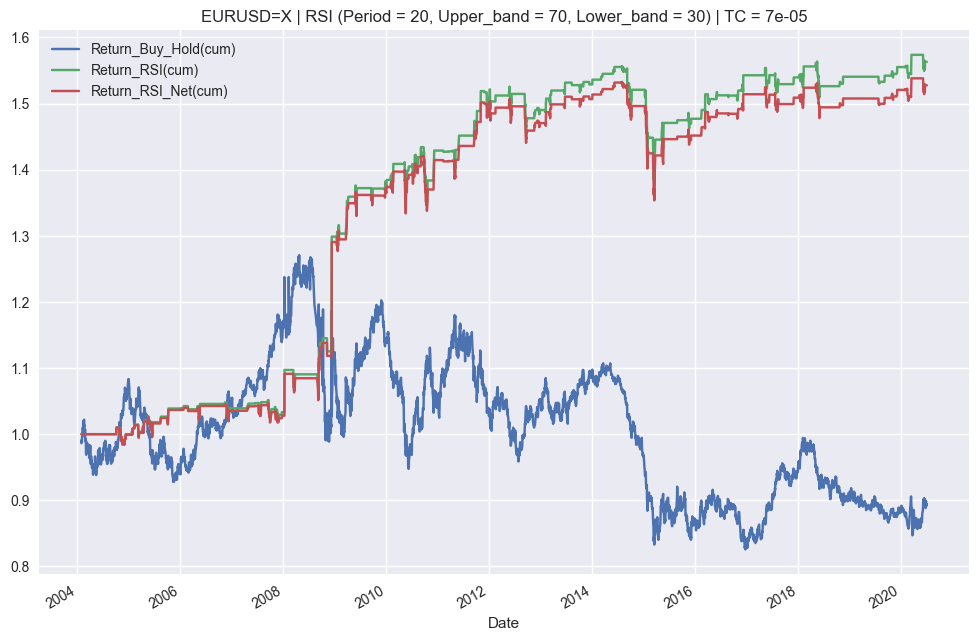

In [13]:
rsi.plot_result()

In [14]:
rsi.optimize_params(period_range=PERIOD_RANGE, rsi_upper_range=RSI_UPPER_RANGE, rsi_lower_range=RSI_LOWER_RANGE)

array([ 6., 65., 20.])